In [1]:
import sys
packages = [
    '../../dataset/',
    '../../utils/',
    '../../optimizer/',
    '../../loss/',
    '../../model/'
]
sys.path.extend(packages)
from sklearn.model_selection import KFold
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from postProcess.post_proc import post_proc,getInstanceArray,getInstancePosi
# 首先先对图片进行染色归一化处理
from StainProcess.StainNormalization import normalizeStaining
from ImageProcess.ImageProcess import cv2Bgr2Rgb
from DataUtil import kfold_list
from util import getNowTime,transformImg,extract_patches,reconstruct_from_patches_weightedall,test_extract_patches
import scipy.io as scio
from metrics import get_fast_aji,remap_label
from scipy import ndimage
from skimage.morphology import label




In [2]:
trains = np.load('../../dataset/kumarDataset/train/testSameDataSet.npy')
gts = np.load('../../dataset/kumarDataset/labels/labelSameDataSet.npy')
val_pred = np.load('./val_0_pred.npz')
train0 = trains[0]
sout = val_pred['sout']
cout = val_pred['cout']
pred = val_pred['pred']
gt0 = gts[0]


In [21]:
# showLineImg([train0,sout,cout,pred,gt0],title=['train0','sout','cout','pred','gt0'])


In [9]:
# 48 176
maxpad = int(176/2)
train0_copy = train0.copy()
train0_copy = np.transpose(train0_copy,(2,0,1))

train0_pad= np.pad(train0_copy,((0,0),(maxpad,maxpad),(maxpad,maxpad)),'reflect')
sout_pad = np.pad(sout,((maxpad,maxpad),(maxpad,maxpad)),'constant',constant_values=0)
cout_pad = np.pad(cout,((maxpad,maxpad),(maxpad,maxpad)),'constant',constant_values=0)
pred_pad = np.pad(pred,((maxpad, maxpad), (maxpad, maxpad)), 'constant', constant_values=0)

print(train0_pad.shape,sout_pad.shape,cout_pad.shape,pred_pad.shape)

(3, 1176, 1176) (1176, 1176) (1176, 1176) (1176, 1176)


In [10]:
cset = np.unique(pred_pad[pred_pad>0])
print(len(cset))

443


(41, 41, 3) (41, 41) (41, 41)
266 98 307 139


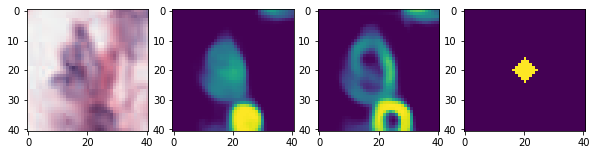

In [16]:
dilation_rate = 2
dilation_s = 0
dilation_c = 2
for index,ic in enumerate(cset):
    icmap = pred_pad.copy()
    icmap[icmap != ic] = 0
    icmap[icmap == ic] = 1 # 获取instance结果
    # 
    if dilation_rate > 0:
        icmap = ndimage.morphology.binary_dilation(icmap, iterations=dilation_rate)
    # 
    if dilation_s > 0:
        dicmap_s = ndimage.morphology.binary_dilation(icmap, iterations=dilation_s)
    elif dilation_s == 0:
        dicmap_s = icmap.copy()
    else:
        dicmap_s = np.ones(icmap.shape)
    # 
    if dilation_c > 0:
        dicmap_c = ndimage.morphology.binary_dilation(icmap, iterations=dilation_c)
    elif dilation_c == 0:
        dicmap_c = icmap.copy()
    else:
        dicmap_c = np.ones(icmap.shape)
    # 获取instance的坐标
    sx,sy,ex,ey = getInstancePosi(icmap) # 获取instance的坐标
    patch_img = train0_pad[:,sx:ex,sy:ey].astype(np.float32)
    patch_sin = sout_pad[sx:ex,sy:ey].astype(np.float32)
    patch_cin = cout_pad[sx:ex,sy:ey].astype(np.float32)
    patch_icmap = icmap[sx:ex,sy:ey].astype(np.float32)
    # 
    patch_img_trans = np.transpose(patch_img,(1,2,0))
    patch_img_trans = patch_img_trans.astype('uint8')
    print(patch_img_trans.shape, patch_sin.shape, patch_cin.shape)
    showLineImg([patch_img_trans, patch_sin, patch_cin,patch_icmap])



    print(sx,sy,ex,ey)
    # plt.imshow(icmap[sx:ex,sy:ey])
    break

